## Propensity score matching - Data Science Portfolio - Maximilian Koch

**Dataset**: Student depression<br>
**Target variable**: Depression (binary)<br>
**Features**: academic performance, family background<br>
**Techniques applied**: Propensity Score Matching<br>


For this part, I chose a dataset on student depression, as available here:
https://www.kaggle.com/datasets/hopesb/student-depression-dataset

### Preprocessing

In [1]:
from psmpy.psmpy import PsmPy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
custom_df = pd.read_csv('datasets/psm_dataset.csv')

In [ ]:
custom_df = custom_df[:10000] #only using part of the data, else the computations take too long
custom_df = custom_df[custom_df['Profession']=='Student']
custom_df = custom_df.drop(columns=['id','City','Profession',
'Job Satisfaction','Work Pressure','Degree','Sleep Duration'])

custom_df = custom_df[custom_df['Dietary Habits']!='Others']
#encoding variables
custom_df['Dietary Habits'] = custom_df['Dietary Habits'].replace({'Unhealthy':0,'Moderate':1,'Healthy':2})
custom_df['Gender'] = custom_df['Gender'].replace({'Male':0,'Female':1}
)
custom_df['Have you ever had suicidal thoughts ?'] = custom_df['Have you ever had suicidal thoughts ?'].replace(
    {'Yes':1,'No':0})
custom_df['Family History of Mental Illness'] = custom_df['Family History of Mental Illness'].replace(
    {'Yes':1,'No':0})
custom_df['Index'] = custom_df.index
custom_df = custom_df.dropna()

C:\Users\mk090\AppData\Local\Temp\ipykernel_14996\1295305850.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  custom_df['Dietary Habits'] = custom_df['Dietary Habits'].replace({'Unhealthy':0,'Moderate':1,'Healthy':2})
C:\Users\mk090\AppData\Local\Temp\ipykernel_14996\1295305850.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  custom_df['Gender'] = custom_df['Gender'].replace({'Male':0,'Female':1}
C:\Users\mk090\AppData\Local\Temp\ipykernel_14996\1295305850.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated

### Propensity scores

In [ ]:
psm = PsmPy(custom_df,treatment='Family History of Mental Illness',indx='Index')
psm.logistic_ps()

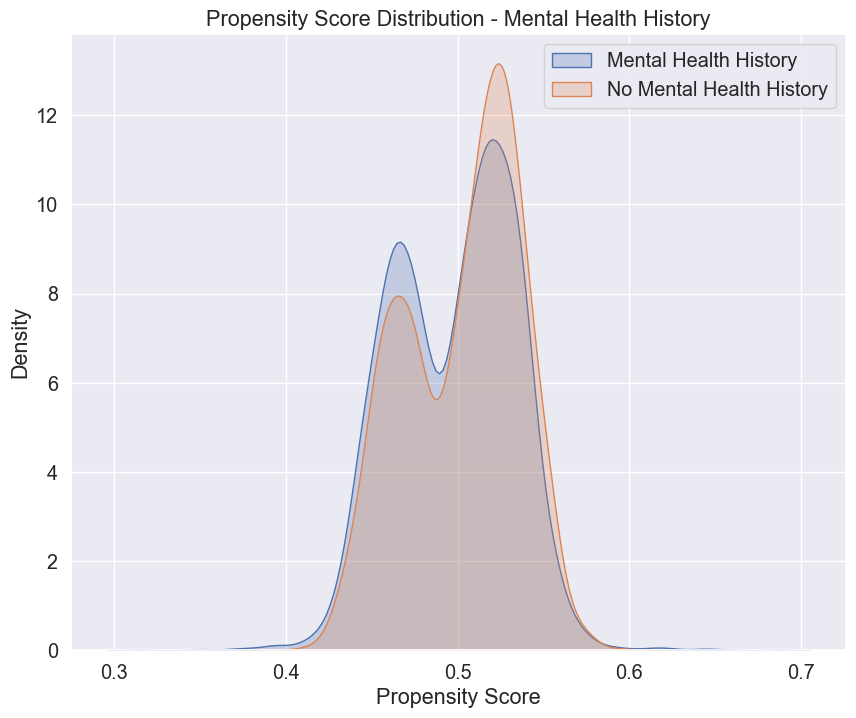

In [ ]:
# Separate propensity scores for each group
fh_0_scores = psm.predicted_data[psm.predicted_data['Family History of Mental Illness'] == 0]['propensity_score']
fh_1_scores = psm.predicted_data[psm.predicted_data['Family History of Mental Illness'] == 1]['propensity_score']

sns.kdeplot(fh_0_scores, label='Mental Health History', fill=True)
sns.kdeplot(fh_1_scores, label='No Mental Health History', fill=True)
plt.title('Propensity Score Distribution - Mental Health History')
plt.xlabel('Propensity Score')
plt.legend()
plt.show()

There is a large overlap/common support. Great.

### Propensity Score Matching

In [ ]:
psm.knn_matched()

Calculate covariate balance using Standardized Mean Differences:

In [ ]:
treated = psm.df_matched[psm.df_matched['Family History of Mental Illness'] == 1]
control = psm.df_matched[psm.df_matched['Family History of Mental Illness'] == 0]
covariates = custom_df.columns.drop(['Index','Family History of Mental Illness'])

In [ ]:
smd_results = {}
for covariate in covariates:
    treated_mean = treated[covariate].mean()
    control_mean = control[covariate].mean()
    treated_std = treated[covariate].std()
    control_std = control[covariate].std()
    
    smd = abs(treated_mean - control_mean) / np.sqrt((treated_std**2 + control_std**2) / 2)
    smd_results[covariate] = smd

In [ ]:
smd_results

{'Gender': 0.01437820511576067,
 'Age': 0.004183170620194205,
 'Academic Pressure': 0.026017454712997105,
 'CGPA': 0.007037603373482198,
 'Study Satisfaction': 0.004693647865529646,
 'Dietary Habits': 0.0033525236106654983,
 'Have you ever had suicidal thoughts ?': 0.015606513767555454,
 'Work/Study Hours': 0.012778918017811383,
 'Financial Stress': 0.010682482535803398,
 'Depression': 0.04827366040183475}

The matching was successful as both groups have quite similar means of observed covariates!
The SMD is low for all variables.

In [ ]:
outcome = 'Depression'

#avg outcome in group with family mental health history
mean_outcome_treated = treated[outcome].mean()
#avg outcome in group without family mental health history
mean_outcome_control = control[outcome].mean()

att = mean_outcome_treated - mean_outcome_control

print('Mean',outcome,'in Treated Group (Family History = 1)',mean_outcome_treated)
print('Mean',outcome,'in Control Group (Family History = 0)',mean_outcome_control)
print('Average Treatment Effect on the Treated:',att)

Mean Depression in Treated Group (Family History = 1) 0.6109158569361174
Mean Depression in Control Group (Family History = 0) 0.587262200165426
Average Treatment Effect on the Treated: 0.023653656770691422


Since in this dataset depression is a binary variable, this corresponds to a 2.4% higher rate in depression in students, where there is a family history of mental illness.